# North American Mushroom Ediblity Classification

(write problem understanding here)
(problem: want to determine rules for deciding if a mushroom is poisonous; should be easy to remember)

## Objectives
- Using Machine Learning, derive easy to remember/utilize decision rules to determine if a mushroom is poisonous
- Should not restrain from using high cardinality features (might be difficult to remember), or features where the levels are difficult to distinguish (unless it being difficult to distinguish does not matter e.g. two similar features tend to be poisonous anyways)
- Should not be overly complicated (easily interpretable by humans). Hence should refrain from using black box models, and limit the complexity. A absolutely perfect model that is overly complicated would be completely useless in the field.
- Should match or exceed human level performance. If perfect accuracy is not attainable, prioritize recall (mushroom is poisonous, but is wrongly classified as being edible). 

### Defining Human Level Performance 
- In a article published in Feburary 2020, the US Agricultural Research Service developed a portable test to detect if a mushroom is poisonous. https://www.mdpi.com/2072-6651/12/2/123/htm
- Hence, we define the target we want to match as the result of the test:

    | Accuracy | True Positive Rate | True Negative Rate |
    |----|----|----|
    | 94.6% | 92.3% | 100% |


In [1]:
!conda install -c conda-forge yellowbrick -y
!conda install -c conda-forge phik -y

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::imageio==2.9.0=py_0
  - conda-forge/linux-64::jupyter_server==1.4.1=py36h5fab9bb_0
  - conda-forge/noarch::black==20.8b1=py_1
  - conda-forge/linux-64::bokeh==2.2.3=py36h5fab9bb_0
  - defaults/linux-64::_anaconda_depends==5.1.0=py36_2
  - conda-forge/noarch::pyls-black==0.4.6=pyh9f0ad1d_0
  - conda-forge/noarch::aiobotocore==1.2.1=pyhd8ed1ab_0
  - conda-forge/noarch::pyls-spyder==0.3.2=pyhd8ed1ab_0
  - conda-forge/linux-64::anyio==2.1.0=py36h5fab9bb_0
  - conda-forge/noarch::jupyterlab_server==2.3.0=pyhd8ed1ab_0
  - conda-forge/linux-64::matplotlib-base==3.3.4=py36hd391965_0
  - conda-forge/linux-64::spyder==4.2.0=py36h5fab9bb_0
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/noarch::seaborn-base==0.11.1=pyhd8ed1ab_1
  - conda-forge/noarch::sphinx==3.5.1=pyhd8ed1ab_0
  - conda-

In [53]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import json

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, get_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

from yellowbrick.model_selection import learning_curve


import phik # phi k correlation 
from phik.report import plot_correlation_matrix, correlation_report
sns.set()

from typing import Union, Tuple, List

In [3]:
dataframe = pd.core.frame.DataFrame

## Importing the Data 
The data format is a comma delimited file. The raw data is provided, without the column names provided as the first row. Hence, column names are manually specified based on the dataset info (`agaricus-lepiota.names`) file. From the dataset info, we also note that null values are denoted by the `?` symbol, and that there are 2480 missing values, all from the **stalk-root** column. 

In [4]:
col_names = [
    "class",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises?",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat"
]
mush_df = pd.read_csv("data/agaricus-lepiota.data", header=None, names = col_names, na_values="?")
mush_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

### Improving Data Readability
Each attribute in the data is currently represented by a single letter. As this can make understanding the data more difficult, we will rename the attributes to be more human readable. I will import a mapping from each letter to the full name of the value.

In [5]:
with open('data/value_map.json') as json_file:
    value_map = json.load(json_file)
    mush_df = mush_df.replace(value_map)
mush_df.head()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,t,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,t,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,t,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,t,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,f,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abudant,grasses


## Data Exploration

### Initial Questions for EDA
- Are the classes in the target label balanced?
- What does the frequency distribution for each categorical feature look like? 
- Are there any features with low variance (e.g. always the same value)?
- Are the missing values in the stalk-root column missing at random?
- Which categorical features have the high Cramer's V correlation with the target?
- What evaluation metric would be most suited for the data and problem?

In [7]:
mush_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [8]:
mush_df.describe().T

,count,unique,top,freq
class,8124,2,edible,4208
cap-shape,8124,6,convex,3656
cap-surface,8124,4,scaly,3244
cap-color,8124,10,brown,2284
bruises?,8124,2,f,4748
odor,8124,9,none,3528
gill-attachment,8124,2,free,7914
gill-spacing,8124,2,close,6812
gill-size,8124,2,broad,5612
gill-color,8124,12,buff,1728


### Looking at Categorical Value Distributions
To make the task of checking out the count distribution of the different columns easier, I've created a function to automatically create a sorted countplot, further separated by the class if necessary.

In [89]:
def show_cat_dist(df: dataframe, columns: Union[List[str], str], hue: Union[str, None] = None, figsize: Tuple[float, float] = (7, 20)):
    fig, ax = plt.subplots(len(columns) if type(columns) is list else 1, 1, figsize=figsize, tight_layout=True)
    if type(columns) is list:
        for idx, feature in enumerate(columns):
            counts = df[feature].value_counts().sort_values(ascending=False)
            ax[idx].set_title("Categorical Distribution of " + feature)
            if hue is None:
        #         sns.catplot(data=df, y=column, kind='bar')
                sns.countplot(y=feature, data=df, order= counts.index, ax = ax[idx])
            else:
        #         sns.catplot(data=df, y=column, hue=hue, kind='bar')
                sns.countplot(y=feature, hue=hue,data=df,order=counts.index, ax = ax[idx])
    else:
            counts = df[columns].value_counts().sort_values(ascending=False)
            ax.set_title("Categorical Distribution of " + columns)
            if hue is None:
        #         sns.catplot(data=df, y=column, kind='bar')
                sns.countplot(y=columns, data=df, order= counts.index, ax = ax)
            else:
        #         sns.catplot(data=df, y=column, hue=hue, kind='bar')
                sns.countplot(y=columns, hue=hue,data=df,order=counts.index, ax = ax)
    return fig, counts


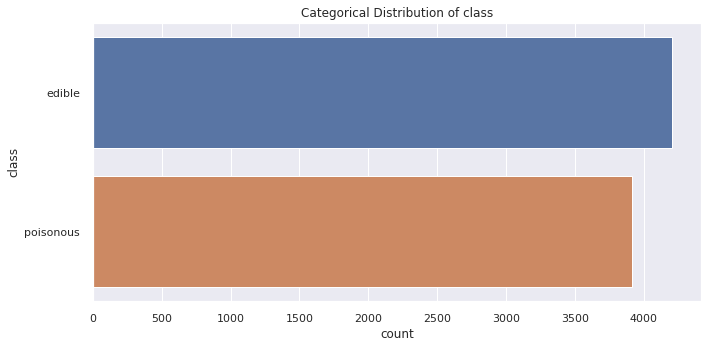

In [87]:
fig, counts = show_cat_dist(mush_df, "class", figsize=(10, 5))

In [29]:
mush_df["class"].value_counts()

edible       4208
poisonous    3916
Name: class, dtype: int64

In [30]:
4208 - 3916

292

There is a relatively even class balance between poisonous and edible mushrooms, with there being 292 more edible mushrooms in the entire dataset as compared to poisonous mushrooms. 

#### General Features

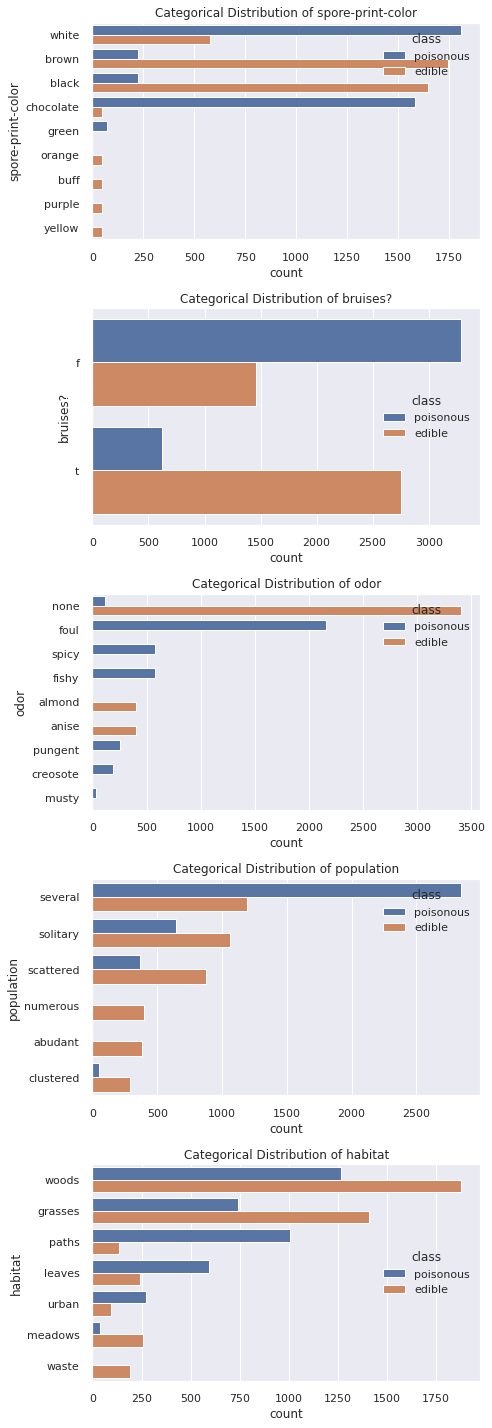

In [88]:
general_features = ['spore-print-color', 'bruises?', 'odor', 'population', 'habitat']

fig, counts = show_cat_dist(mush_df, general_features, "class")

fig.show()

#### Mushroom Cap Features

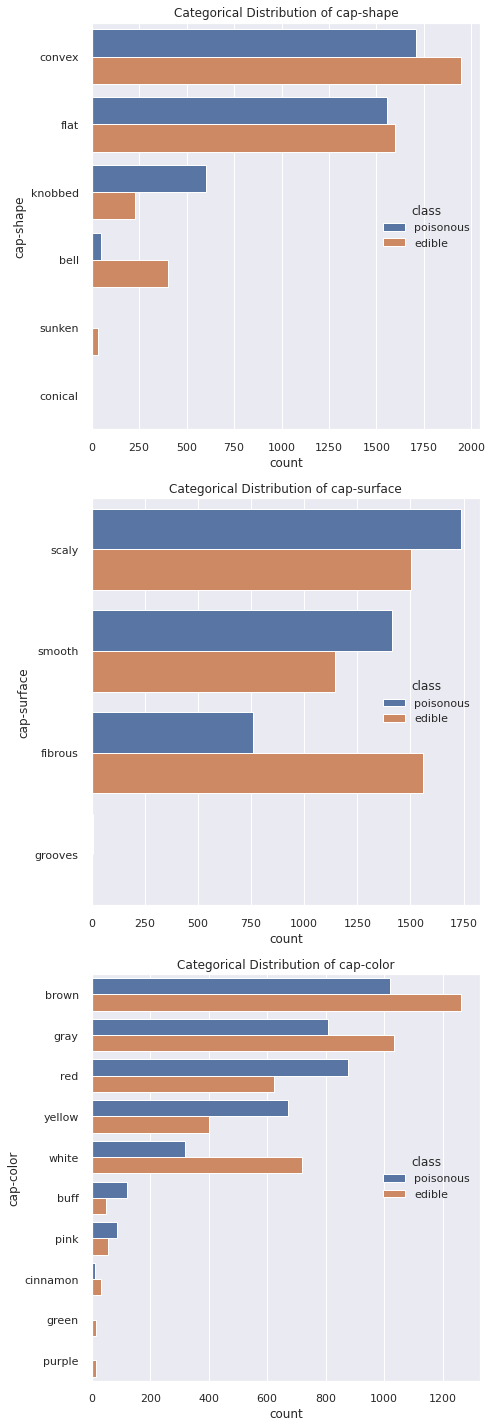

In [90]:
cap_features = ['cap-shape', 'cap-surface', 'cap-color']
fig, counts = show_cat_dist(mush_df, cap_features, "class")

fig.show()

#### Gill Features

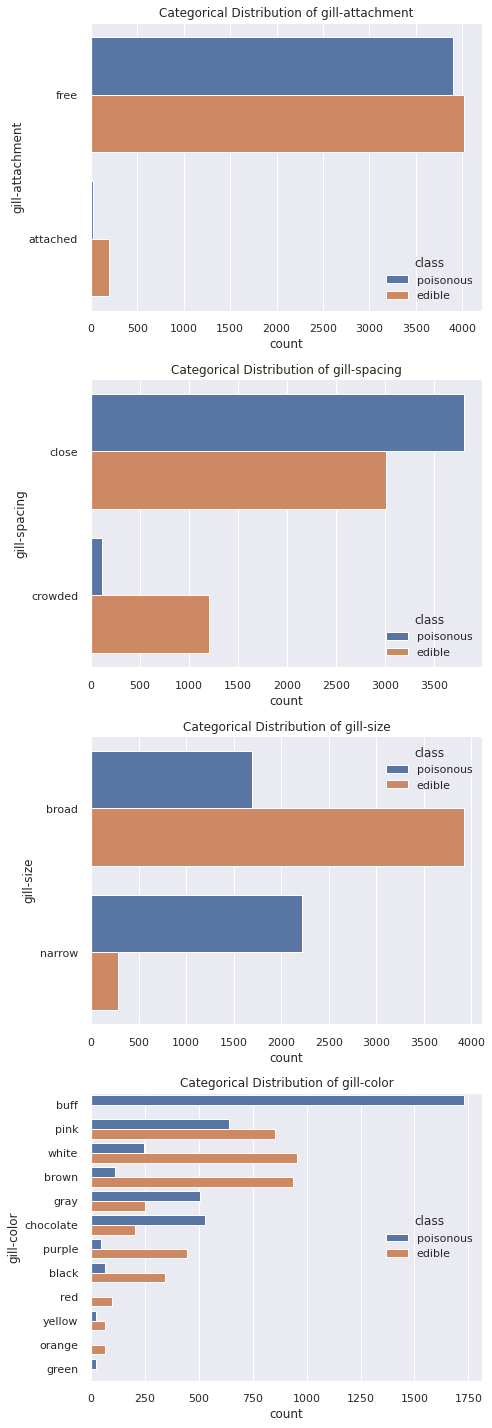

In [91]:
gill_features = ['gill-attachment', 'gill-spacing', 'gill-size', 'gill-color']
fig, counts = show_cat_dist(mush_df, gill_features, "class")

fig.show()

#### Stalk Features

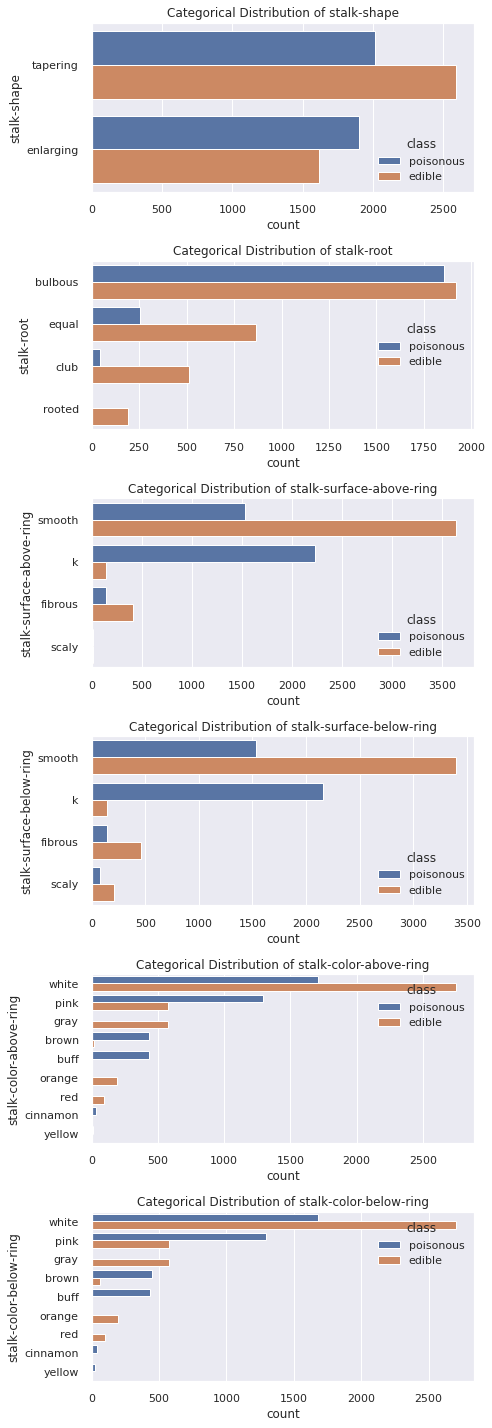

In [92]:
stalk_features = ['stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring']
fig, counts = show_cat_dist(mush_df, stalk_features, "class")

fig.show()

#### Veil Features

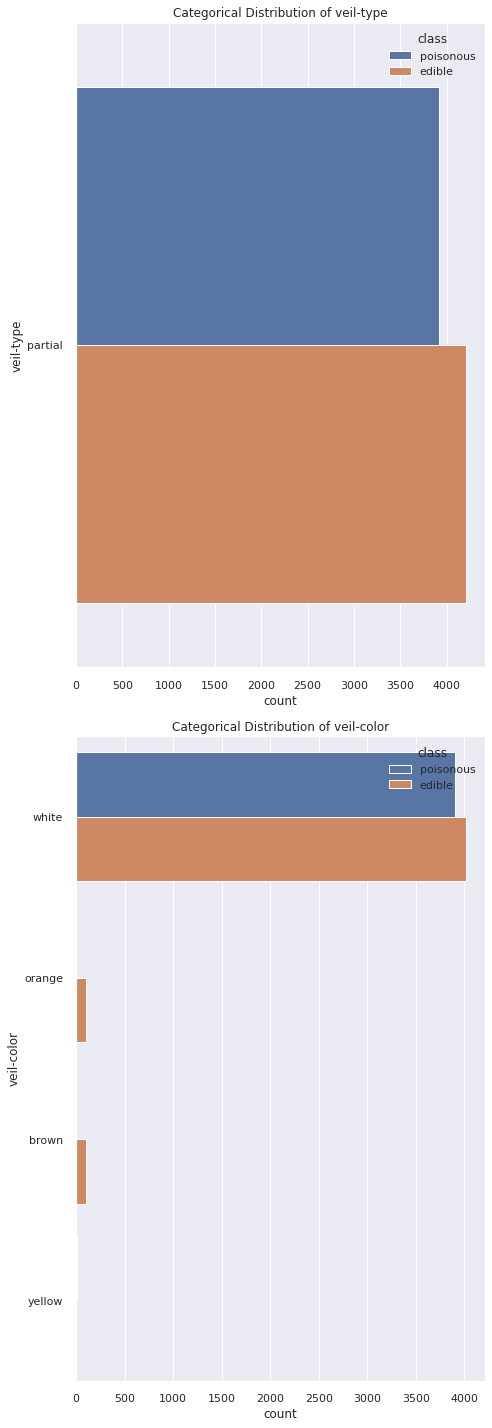

In [93]:
veil_features = ['veil-type', 'veil-color']
fig, counts = show_cat_dist(mush_df, veil_features, "class")

fig.show()

#### Ring Features

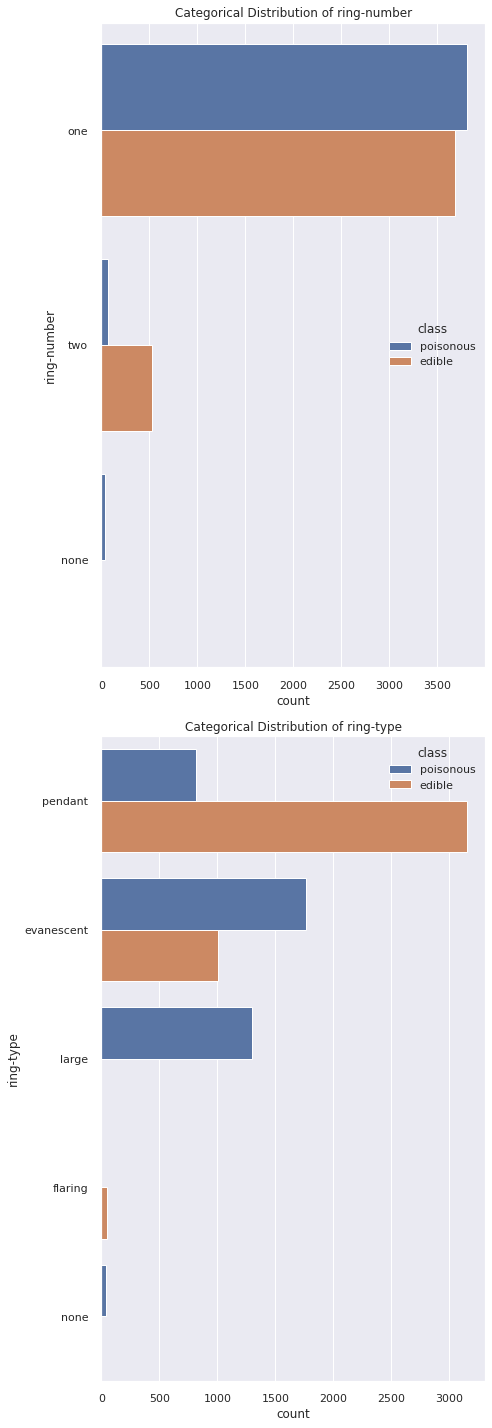

In [94]:
ring_features = ['ring-number',
       'ring-type']
fig, counts = show_cat_dist(mush_df, ring_features, "class")

fig.show()

#### Summary of Insights From Checking the Distribution of Categorical Variables

### Checking for Low Variance Features

For later feature selection, we wish to know which features almost always have the same value, as it would limit the usefulness of the feature.

In [105]:
mush_df.apply(lambda x : (x.value_counts() / len(mush_df) * 100).max(), axis = 0).sort_values(ascending=False)

veil-type                   100.000000
veil-color                   97.538159
gill-attachment              97.415066
ring-number                  92.171344
gill-spacing                 83.850320
gill-size                    69.079271
stalk-surface-above-ring     63.712457
stalk-surface-below-ring     60.758247
bruises?                     58.444116
stalk-shape                  56.720827
stalk-color-above-ring       54.948301
stalk-color-below-ring       53.963565
class                        51.797144
population                   49.729197
ring-type                    48.842935
stalk-root                   46.479567
cap-shape                    45.002462
odor                         43.426883
cap-surface                  39.931068
habitat                      38.749385
spore-print-color            29.394387
cap-color                    28.114229
gill-color                   21.270310
dtype: float64

We observe that all mushrooms have the same veil type (also supported by our previous plots), and that most mushrooms have the same veil color, gill attachment, ring number and gill spacing.

## Data Preprocessing

### Separate Features and Labels

In [ ]:
X, y = mush_df.drop('class', axis = 1), mush_df["class"]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
y

### Splitting Data into Training and Test Set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)

### Data Preprocessing Pipeline: One-Hot Encoding

In [ ]:
data_preprocess_steps = [
    ('Imputer', SimpleImputer(strategy='most_frequent')), # impute missing values with most frequent value
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore')) # one hot encode categorical data. We don't drop for other catergorical features as we want to make the features more interpretible (at cost to having extra dimensions in the data)
]
data_preprocessing = Pipeline(data_preprocess_steps)

## Modelling: Initial Baseline Model

In [ ]:
from sklearn.dummy import DummyClassifier
clf = Pipeline(data_preprocess_steps + [
    ('Baseline Model', DummyClassifier(strategy="most_frequent"))
])

## Model Evaluation
To standardize the way the model is evaluated, we will create a function to automatically evaluate the model. 

It will:
- Get the score of the model on the cross-validation set.
- Get the score of the model on the hold-out set.
- Generate the learning curve of the candidate model.
- Generate a confusion matrix
- Plot ROC Curve
- Return the trained model (trained on the entire training set), if specified

In [ ]:
def evalCandidateModel(model, X_train, X_test, y_train, y_test, scoring = 'accuracy', cv = 5, return_learning_curve = True):
    scores = cross_validate(model, X_train, y_train, scoring=scoring, return_estimator=True, return_train_score=True, cv=cv)
    best_estimator = scores["estimator"][np.argmax(scores["test_score"])]
    del scores["estimator"]
    scores = pd.DataFrame(scores)
      # If a hold out set is provided
    if X_test is not None and y_test is not None:
        scorer = get_scorer(scoring) # Then also score it, based off the scoring scheme provided
        scores["hold_out_score"] = scorer(best_estimator, X_test, y_test)
    # If user wants to create a learning_curve
        y_pred = best_estimator.predict(X_test)
        report = classification_report(y_test, y_pred)
        matrix = confusion_matrix(y_test, y_pred)
    if return_learning_curve:
        fig = learning_curve(model, X_train, y_train, scoring = scoring, n_jobs=-1, random_state = 42, cv =cv, show = False)
    else:
        fig = None # Else, return nothing
    return scores.describe().iloc[1:3, 2:].round(5), report, matrix ,fig,best_estimator


In [ ]:
def evalHistory(new_score, model_name, history = None):
    if history is None:
        history = pd.DataFrame()
    new_score =new_score.iloc[0, :]
    new_score.rename(index=model_name, inplace=True)
    history = history.append(new_score)
    return history

In [ ]:
scores, report, matrix, fig, baseline = evalCandidateModel(clf, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Baseline (Mode Predictor)")
display(scores)
print(report)
print(matrix)



In [ ]:
plot_roc_curve(baseline, X_test, y_test)

In [ ]:
history

The baseline classifier 

## Modelling: Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = Pipeline(data_preprocess_steps + [
    ('Baseline Model', DecisionTreeClassifier(max_depth=2))
])

In [ ]:
scores,report, matrix, fig, dt = evalCandidateModel(clf, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Decision Tree", history)
display(scores)

In [ ]:
history

In [ ]:
plot_roc_curve(dt, X_test, y_test)

In [ ]:
tree = clf[-1]
feature_names = clf[-2].get_feature_names(X.columns)
from sklearn.tree import plot_tree 
plt_tree = plot_tree(dt, feature_names=feature_names)
